In [91]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import OneQubitEulerDecomposer

import matplotlib.pyplot as plt

import numpy as np

# Single-qubit controlled-U gate construction

My approach is based off of Barenco et al, "Elementary gates for quantum computation", 1995 (https://arxiv.org/pdf/quant-ph/9503016), specifically Lemmas 4.3 and 5.1. The lemmas (pictured below for convenience) give a useful way to decompose U into arbitrary 1-qubit gates such that a controlled-U gate can be formed from these gates composed with CX gates. 

<img src="./images/lemma-43.png" alt="isolated" width="800"/>
<img src="./images/lemma-43-proof.png" alt="isolated" width="800"/>
<img src="./images/lemma-51.png" alt="isolated" width="800"/>

True


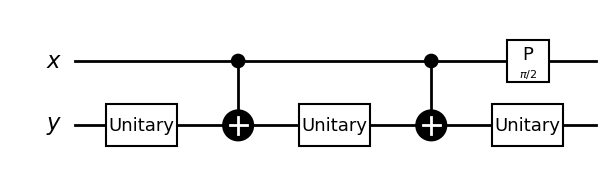

In [ ]:
def controlled_U_gate(U):
    
    #decompose U into a z-y-z angle decomposition
    #U = e^ix * Rz(a)Ry(b)Rz(c)
    basis = 'ZYZ'
    angles = OneQubitEulerDecomposer(basis).angles_and_phase(U)

    Rz1 = Operator([[np.exp(-1j*angles[0]/2), 0], [0, np.exp(1j*angles[0]/2)]])
    Ry = Operator([[np.cos(angles[1]/2), -np.sin(angles[1]/2)],
                   [np.sin(angles[1]/2), np.cos(angles[1]/2)]])
    Rz2 = Operator([[np.exp(-1j*angles[2]/2), 0], [0, np.exp(1j*angles[2]/2)]])

    #U should equal np.exp(1j*angles[3]) * Rz1 @ Ry @ Rz2
    
    #define A, B, C according to theory described above
    A = Operator(Rz1 @ Operator([[np.cos(angles[1]/4), -np.sin(angles[1]/4)],
                   [np.sin(angles[1]/4), np.cos(angles[1]/4)]]))
    B = Operator(Operator([[np.cos(angles[1]/4), np.sin(angles[1]/4)],
                   [-np.sin(angles[1]/4), np.cos(angles[1]/4)]]) @ Operator([[np.exp(-1j*(-angles[2]/2 - angles[0]/2)/2), 0], [0, np.exp(1j*(-angles[2]/2 - angles[0]/2)/2)]]))
    C = Operator([[np.exp(-1j*(angles[2]/2 - angles[0]/2)/2), 0], [0, np.exp(1j*(angles[2]/2 - angles[0]/2)/2)]])

    X = Operator([[0, 1], [1, 0]])

    #check that A, B, C satisfy the conditions of the lemmas
    AXBXC = A @ X @ B @ X @ C
    eAXBXC = np.exp(1j*angles[3]) * AXBXC

    print(np.allclose(eAXBXC, U) and np.allclose(A @ B @ C, np.eye(2)))  #should be true if A, B, C, and phase are correct


    #now define quantum circuit
    quantum_registerXs = QuantumRegister(size=1, name="x")
    quantum_registerY = QuantumRegister(size=1, name="y")

    cUckt = QuantumCircuit(quantum_registerXs,quantum_registerY, name="controlled-U")

    cUckt.append(UnitaryGate(C), [quantum_registerY[0]]) #gates are applied in reverse order to match multiplication order
    cUckt.cx(quantum_registerXs[0], quantum_registerY[0])
    cUckt.append(UnitaryGate(B), [quantum_registerY[0]])
    cUckt.cx(quantum_registerXs[0], quantum_registerY[0])
    cUckt.append(UnitaryGate(A), [quantum_registerY[0]])
    cUckt.p(angles[3], quantum_registerXs[0]) #controlled global phase equiv to single phase on control qubit
    
    return cUckt

cUckt = controlled_U_gate(Operator([[0, 1], [1, 0]]))
cUckt.draw(output="mpl", style="bw")

## Method Verification

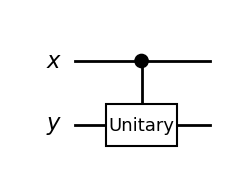

In [87]:
#doing the same thing using qiskit's built-in controlled function for comparison
def controlled_U_gate2(U):
    quantum_registerXs = QuantumRegister(size=1, name="x")
    quantum_registerY = QuantumRegister(size=1, name="y")
    cUckt = QuantumCircuit(quantum_registerXs,quantum_registerY, name="controlled-U")
    U = UnitaryGate(U).control(1)
    cUckt.append(U, [quantum_registerXs[0], quantum_registerY[0]])
    return cUckt

cUckt2 = controlled_U_gate2(Operator([[0, 1], [1, 0]]))
cUckt2.draw(output="mpl", style="bw")

In [88]:
#checking equivalence of the two circuits
Op1 = Operator(cUckt)
Op2 = Operator(cUckt2)

print(Op1.equiv(Op2))
print(Statevector.from_instruction(cUckt).equiv(Statevector.from_instruction(cUckt2)))

True
True


# Expanding to arbitrary n

## Method verification

In [89]:
#trying to implement multi-controlled-U gate
def multi_controlled_U_gate(U, n):
    quantum_registerXs = QuantumRegister(size=n, name="x")
    quantum_registerY = QuantumRegister(size=1, name="y")
    #ancilla_register = AncillaRegister(size=n, name="y")

    mcUckt = QuantumCircuit(quantum_registerXs, quantum_registerY, name="multi-controlled-U")

    U = UnitaryGate(U).control(n)
    mcUckt.append(U, [quantum_registerXs[i] for i in range(n)] + [quantum_registerY[0]])
    
    return mcUckt

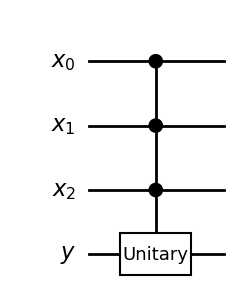

In [90]:
mcUckt = multi_controlled_U_gate(Operator([[1, 0], [0, 1]]),3)
mcUckt.draw(output="mpl", style="bw")